# 예측 애널리틱스: 부스팅

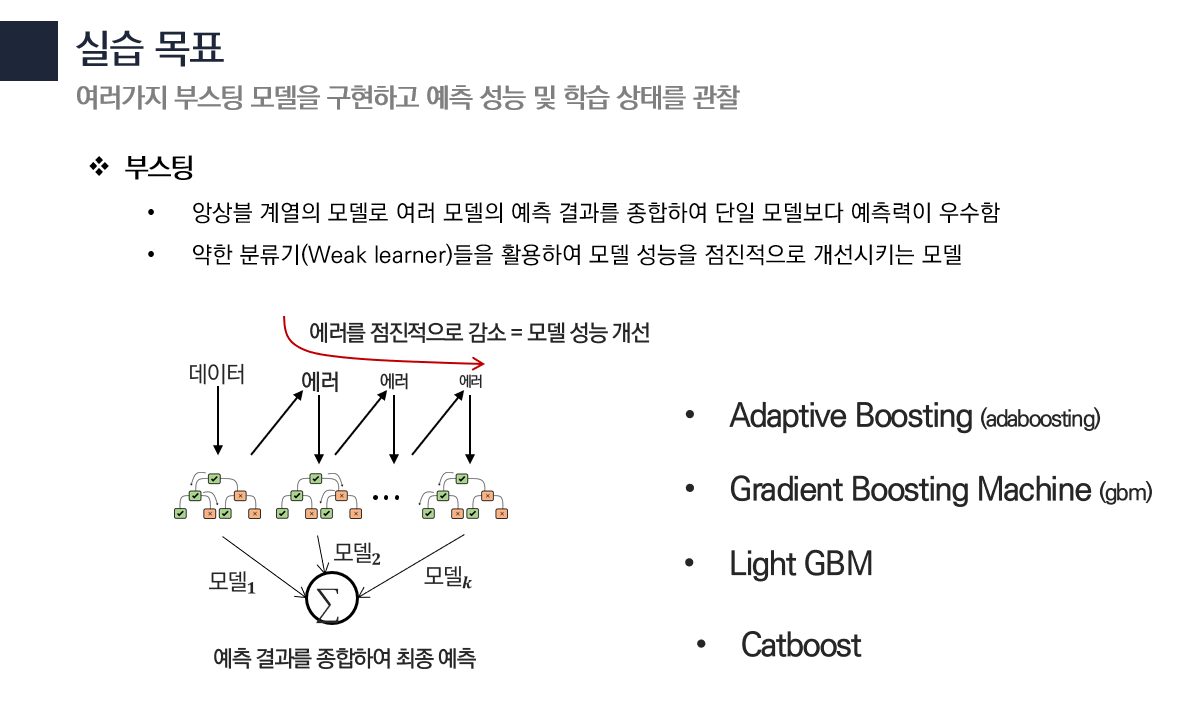

# 1. 모듈 및 데이터 불러오기

## 1.1 모듈 불러오기

In [ ]:
# 데이터 전처리
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 기계학습 모델 생성, 학습, 평가
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier # 패키지 설치하세요 ~ !pip install lightgbm
from catboost import CatBoostClassifier # 패키지 설치하세요 ~ !pip install catboost
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import torch
from sklearn.metrics import accuracy_score
device = torch.cuda.is_available() 
# Catboost와 Lightgbm은 gpu 사용이 가능합니다 ! Gpu 장비와 cuda 설치가 되어있다면 활용하면 좋습니다! (학습 시간 단축)
# Cpu로도 학습 충분히 가능합니다


# 시각화 & 편의용
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from tqdm import tqdm
import pickle
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams['axes.unicode_minus'] = False

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')

## 1.2 Wine 데이터 : 와인에 대한 화학적 성분들을 기반하여 와인의 품질을 예측

#### 설명변수 및 반응변수
- fixed acidity - 고정산, 와인의 산도와 연관됨 (연속형) <br>
- volatile acidity - 휘발산, 와인의 향과 연관됨 (연속형) <br>
- citric acid - 구연산, 와인의 신선함을 올림 (연속형) <br>
- residual sugar - 잔여 당분, 와인의 단 맛을 올림 (연속형) <br>
- chlorides - 염화물, 와인의 짠 맛의 원인 (연속형) <br>
- free sulfur dioxide - 황 화합물, 와인을 오래 보관하게 함 (연속형) <br>
- total sulfur dioxide - 황 화합물, 와인을 오래 보관함하게 함 (연속형) <br>
- density - 밀도, 와인의 무게감을 나타냄 (연속형) <br>
- pH - 산성도, 와인의 신 맛의 정도 (연속형) <br>
- sulphates - 황 화합물, 와인을 오래 보관하게 함 (연속형) <br>
- alcohol - 알코울, 와인의 단 맛과 무게감에 영향 (연속형) <br>
- <span style="color:blue">quality - 와인등급   <b>[타겟 변수] (10 class 범주형)</b> <br></span>

In [ ]:
data = pd.read_csv('./winequality-red.csv',sep=';')
X , y = data.drop(['quality'],axis=1) , data['quality']

# 2. 여러가지 부스팅 모델에 대한 학습 방법 및 하이퍼파라미터 소개

## 2.1 하이퍼파라미터 소개

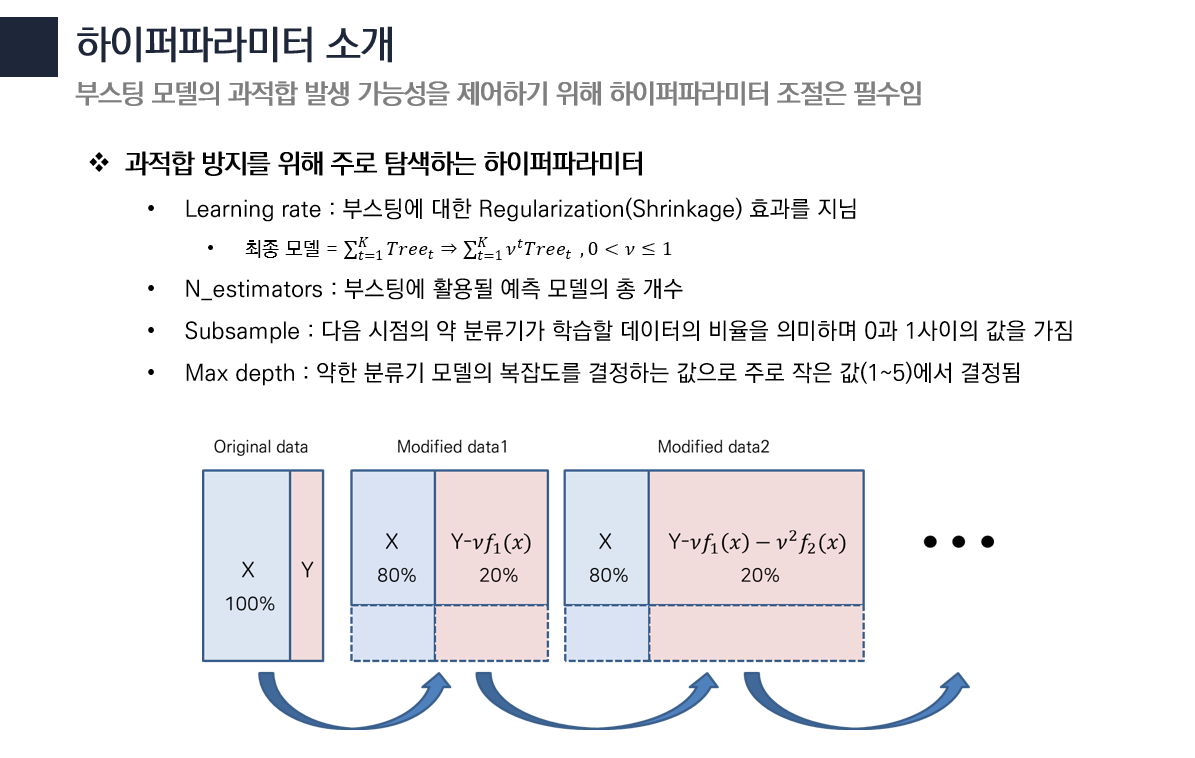

## 2.2 모델 특징 소개

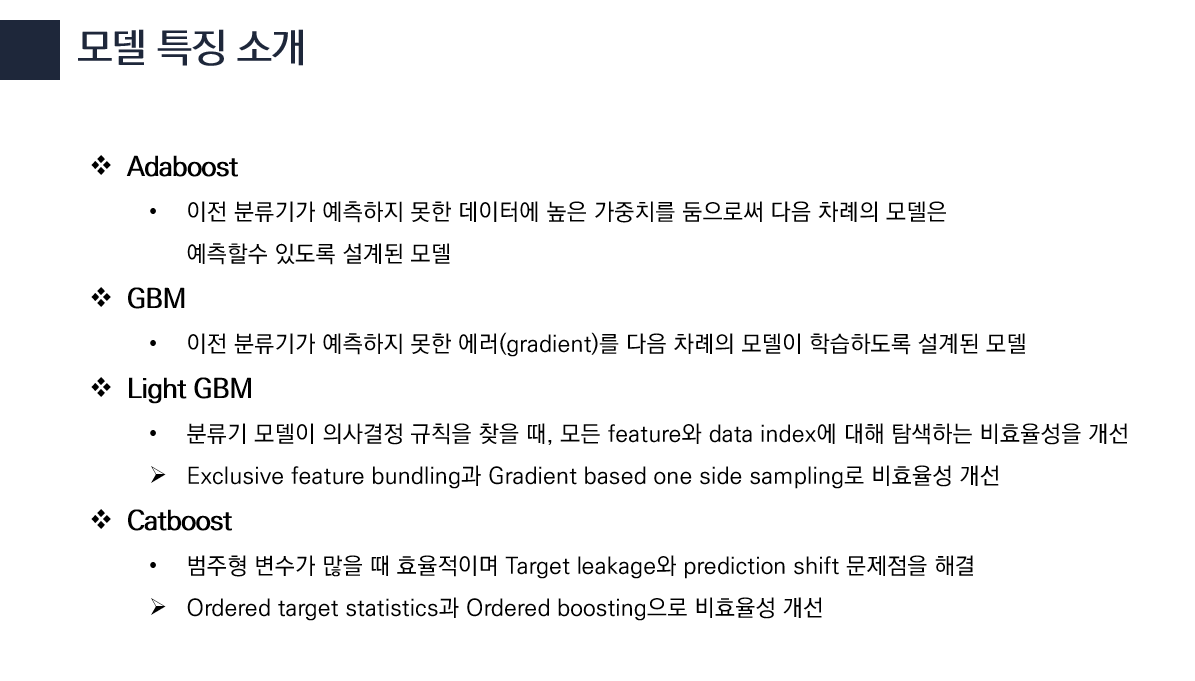

## 2.3 학습

In [ ]:
## 탐색하고자 하는 하이퍼파라미터 설정 ## 
model_params = {"GBM": {'model': GradientBoostingClassifier(random_state=0), # 그레디언트 부스팅
                        'params': { 'learning_rate': [0.2*(i+1) for i in range(3)], # 학습률, Shrinkage율
                                    'n_estimators': [50*(i+1) for i in range(3)] , 
                                    'subsample':[0.5,0.75,1.0],
                                    'max_depth':[i for i in range(1,11,2)]
                                  }},

                "AdaBoost": {'model': AdaBoostClassifier(random_state=0),# 에이다 부스팅
                        'params': {'base_estimator':  [DecisionTreeClassifier(max_depth=i) for i in range(1,11,2)], # 약분류기 (주로 의사결정나무를 사용)
                                   'n_estimators':[50*(i+1) for i in range(3)], 
                                   'learning_rate':[0.2*(i+1) for i in range(3)]}},
                
                'Light GBM' : {'model' : LGBMClassifier(random_state=0, silent=True, device='gpu') if device == True else LGBMClassifier(random_state=0, silent=True),
                          'params' : {'max_depth':[i for i in range(1,11,2)],
                                      'n_estimators':[50*(i+1) for i in range(3)],
                                      'learning_rate': [0.2*(i+1) for i in range(3)]
                                     }},
                
                'Catboost' : {'model' : CatBoostClassifier(random_seed=0, silent=True, task_type = 'GPU', thread_count = 5 , gpu_ram_part = .5) if device == True else CatBoostClassifier(random_seed=0, silent=True), 
                              'params' : {'max_depth':[i for i in range(1,11,2)] ,
                                          'n_estimators':[50*(i+1) for i in range(3)],
                                          'learning_rate': [0.2*(i+1) for i in range(3)]
                                     }}
                                    }

In [ ]:
# seeds = [0 for i in range(10)]
seeds = [0]
pbar = tqdm(total=len(model_params)*len(seeds)) # tqdm은 학습 상태가 어느정도 됬는지 파악해주는데 유용한 함수입니다.
output = pd.DataFrame([]) # 학습 결과를 저장하기 위한 객체 생성

for seed in seeds:
    
    X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = .2 , random_state = seed) # train, test 분리
    
    # Standard scaler를 이용한 변수 scaling # 
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 4가지 모델에 대한 학습 시작 # 
    for model_name, v in model_params.items():

        pbar.set_description(desc=f"{model_name}") # tqdm에서 활용되는 옵션입니다. 현재 학습되고 있는 모델 이름을 출력합니다.
        
        model, params = v['model'], v['params']
        gcv = GridSearchCV(estimator=model, param_grid=params, n_jobs=2 if model_name == 'Catboost' else 5, cv=5, scoring='accuracy')
        gcv.fit(X_train_scaled, y_train)
        
        result = pd.DataFrame.from_dict(gcv.cv_results_) # cv_results에는 각 fold별 예측 성능이 기록되어 있습니다.
        result['test_accuracy_with_best_hyp'] = accuracy_score(y_pred = gcv.predict(X_test_scaled) , y_true = y_test) #gcv.predict()는 최적 하이퍼파라미터가 탑재된 모델의 예측 결과를 파악하는데 사용됩니다.
        result['model_name'] = model_name
        result['seed'] = seed
        output = pd.concat([output,result])
        pbar.update(1)

output.reset_index(drop=True)       
output.to_csv('./classification_result.csv')

## 2.4 학습 결과 확인

### 하이퍼파라미터 종류별 예측 성능에 대한 영향을 개략적으로 시각화한 코드

In [ ]:
output = pd.read_csv('./classification_result.csv',index_col=0)
model_name = 'Catboost' # GBM , AdaBoost, Light GBM, Catboost

for_plot_values = output.loc[ output['model_name'] == model_name,:] # 예측 모델별 결과 확인을 위한 indexing

fig , axs = plt.subplots(nrows=model_params[model_name]['params'].keys().__len__(), ncols=1, figsize=(50,80)) # plot configure
fig.suptitle(f'{model_name} performance for each hyperparameter',fontsize=50) # 전체 Plot 제목

for ind , param_key in enumerate(model_params[model_name]['params'].keys()):
    
    param_for_plot = for_plot_values.groupby([f'param_{param_key}'])['mean_test_score'].mean() # 조절 하이퍼파라미터 이외에 대해서는 평균 성능 (개략적)
    
    axs[ind].bar(height = param_for_plot.values,x = [i for i in range(param_for_plot.values.shape[0])]) # bar plot 
    axs[ind].tick_params(axis='both',labelsize=20) # x,y 축 글씨 폰트 설정
    
    axs[ind].set_xticks([i for i in range(param_for_plot.values.shape[0])]) # x 축 ticks 설정
    axs[ind].set_xticklabels(param_for_plot.index.to_list()) # x 축 ticks 이름 설정

    axs[ind].set_title(f'{param_key}',fontsize=50) # 내부 plot 제목 

### 모든 하이퍼파라미터 조합에 따른 예측 성능 시각화

In [ ]:
output = pd.read_csv('./classification_result.csv',index_col=0)
fig , axs = plt.subplots(nrows=len(model_params), ncols=1, figsize=(50,80))
fig.suptitle('Model performance for each hyperparameter',fontsize=50)
for ind, model_name in enumerate(model_params):
    for_plot_values = output.loc[ output['model_name'] == model_name,:] # model_name 데이터만 인덱싱
    axs[ind].bar(height = for_plot_values['mean_test_score'] , x = [i for i in range(for_plot_values.shape[0])]) # 모든 하이퍼파라미터 조합에 따른 예측 성능 시각화
    axs[ind].tick_params(axis='y',labelsize=50)
    axs[ind].set_title(f'{model_name}',fontsize=50)

In [ ]:
## 최적의 하이퍼파라미터를 탑재한 예측 모델의 K-fold 예측 성능 시각화

plt.figure(figsize=(10,10))
output.groupby(['model_name'])['mean_test_score'].max().plot.bar()
plt.title('Predictive performance of models with optimal hyperparameters',fontsize=20)
plt.yticks(fontsize=20)
plt.show()

## 2.5 하이퍼파라미터 세밀하게 탐색 (your option) 

In [ ]:
# 추가 하이퍼파라미터 탐색 ( 촘촘하게 )
model_params = {"GBM": {'model': GradientBoostingClassifier(random_state=0),
                        'params': { 'learning_rate': list(np.arange(0.05,0.20,0.01)),# 0.2 근처 혹은 작을수록 좋은 성능을 보였음
                                    'n_estimators': [50] , # 너무 많은 모델 개수를 필요로 하지 않아 보였음 (50에서 가장 Best)
                                    'subsample':[1.0], # 1에 가까울수록 좋은 성능을 보였음
                                    'max_depth':[7,8,9] # 7과 9 사이에서 더 조밀하게 탐색
                                  }},

                "AdaBoost": {'model': AdaBoostClassifier(random_state=0),
                        'params': {'base_estimator':  [DecisionTreeClassifier(max_depth=i) for i in [7,8,9]], # 7과 9 사이에서 더 조밀하게 탐색
                                   'n_estimators':[50], # 너무 많은 모델 개수를 필요로 하지 않아 보였음 (50에서 가장 Best)
                                   'learning_rate':list(np.arange(0.05,0.20,0.01))}},
                
                'Light GBM' : {'model' : LGBMClassifier(random_state=0, silent=True, device='gpu') if device == True else LGBMClassifier(random_state=0, silent=True),
                          'params' : {'max_depth':[1,2,3], # 작을수록 좋은 성능을 보였음
                                      'n_estimators':[100], # 성능에 큰 영향을 미치는 것으로 판단되지 않음
                                      'learning_rate': list(np.arange(0.05,0.20,0.01))}},# 작을수록 좋은 성능을 보였음
                
                'Catboost' : {'model' : CatBoostClassifier(random_seed=0, silent=True, task_type = 'GPU', thread_count = 5 , gpu_ram_part = .5) if device == True else CatBoostClassifier(random_seed=0, silent=True), 
                              'params' : {'max_depth':[8,9,10] , # 9 근처에서 좋은 성능을 보였으니, 11 근방 탐색
                                          'n_estimators':[150], # 성능에 큰 영향을 끼치지 않을 것으로 판단됨.
                                          'learning_rate': list(np.arange(0.05,0.20,0.05)) # 다른 모델보단 성능에 둔감하게 영향을 끼침. rough하게 탐색
                                     }}}

# Train
# seeds = [0 for i in range(10)]
seeds = [0]
pbar = tqdm(total=len(model_params)*len(seeds))
output = pd.DataFrame([])

for seed in seeds:
    
    X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = .2 , random_state = seed)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    for model_name, v in model_params.items():

        pbar.set_description(desc=f"{model_name}")
        model, params = v['model'], v['params']
        gcv = GridSearchCV(estimator=model, param_grid=params, n_jobs=2 if model_name == 'Catboost' else 5, cv=5, scoring='accuracy')
        gcv.fit(X_train_scaled, y_train)
        
        result = pd.DataFrame.from_dict(gcv.cv_results_)
        result['test_accuracy_with_best_hyp'] = accuracy_score(y_pred = gcv.predict(X_test_scaled) , y_true = y_test)
        result['model_name'] = model_name
        result['seed'] = seed
        output = pd.concat([output,result])
        pbar.update(1)

output.reset_index(drop=True)       
output.to_csv('./classification_result2.csv')

## 2.6 테스팅 데이터에 대한 최종 예측 성능 관찰

In [ ]:
## 최적의 하이퍼파라미터를 탑재한 예측 모델의 테스팅 데이터 예측 성능 시각화

output = pd.read_csv('./classification_result.csv',index_col=0)
output.reset_index(drop=True,inplace=True) # index 초기화 
plt.figure(figsize=(10,10))

idx = output.groupby(['model_name'])['mean_test_score'].idxmax() # 각 모델별 검증용 accuracy를 기준하여, Best 성능을 기록한 경우 추출
output.loc[idx,['model_name','test_accuracy_with_best_hyp']].set_index('model_name').plot.bar(legend=False)
plt.title('Predictive performance of models with optimal hyperparameters',fontsize=20)
plt.yticks(fontsize=20)
plt.show()

# E.O.D